In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from IPython.display import Image

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv")
df

In [ ]:
plt.hist(df["age"])

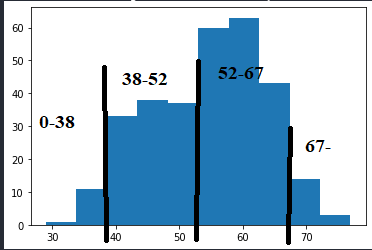

In [ ]:
def age_group(x):
    if x < 38:
        return 0
    if x < 52:
        return 1
    if x < 67:
        return 2
    return 3

In [ ]:
df["age"] = df["age"].apply(lambda x : age_group(x))
df

### Categoricals -> "age", "cp", "slp", "caa", "thall"

### And since we use linear regression we must avoid dummy trap

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Avoid Dummy Trap

##### We can avoid dummy trap by doing drop first column for every categoricals

In [ ]:
categoricals = ["age", "cp", "slp", "caa", "thall"]

In [ ]:
df["age"].unique()

In [ ]:
df["cp"].unique()

In [ ]:
dummys = [0]
for i in categoricals:
    dummys.append(dummys[-1] + len(df[i].unique()))

In [ ]:
dummys

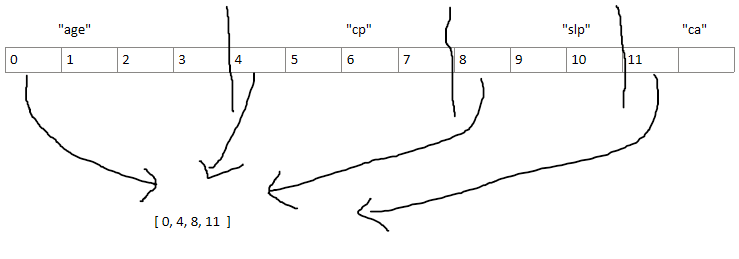

In [ ]:
ct = ColumnTransformer(transformers= [ ( "encoder", OneHotEncoder(), categoricals ) ], remainder="passthrough")

In [ ]:
df = pd.DataFrame(ct.fit_transform(df))
df

In [ ]:
df

In [ ]:
df = df.drop(columns = dummys)
df

## Standard Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
sc = StandardScaler()

### We need to scale column 21,22,25,27

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(df.iloc[ : , :-1], df.iloc[: , -1:], test_size = 0.2)

In [ ]:
for i in (21,22,25,27):
    X_train[i] = sc.fit_transform(X_train[i].values.reshape(-1,1))
    X_test[i] = sc.transform(X_test[i].values.reshape(-1,1))

In [ ]:
X_train

## First try sklearn library

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
reg = LogisticRegression()

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
reg.fit(X_train, y_train)

In [ ]:
accuracy_score(y_test, reg.predict(X_test))

## Our Algorithm

In [ ]:
from sympy import *

In [ ]:
Image('../input/image1/1.png')

### Let's look at the formulas above and create our hypothesis

We can use PCA for our algorithm

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)

In [ ]:
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
X_train[0:1]

##### Our data has 5 parameters

#### h = t0 + t1*x1 + t2*x2 + t3*x3 + t4*x4 + t5*x5

In [ ]:
p_num = 5

In [ ]:
theta_symbols = []
x_symbols = []
y = Symbol("y")
for i in range(p_num + 1):
    theta = "t" + str(i)
    x = "x" + str(i)
    theta_symbols.append(Symbol(theta))
    x_symbols.append(Symbol(x))

In [ ]:
h_function = theta_symbols[0]
for i in range(1,p_num + 1):
    h_function += theta_symbols[i] * x_symbols[i]

In [ ]:
h_function

In [ ]:
cost_function = (h_function - y)**2

In [ ]:
Image('../input/image1/2.png')

#### And now we can tune parameters using gradient decent algorithm

In [ ]:
Image('../input/image1/3.jpg')

In [ ]:
learning_rate = 0.1
m = 242 # X_train has 242 rows

In [ ]:
Image('../input/image2/1.png')

In [ ]:
Image('../input/image3/Untitled.png')

Initially we choose theta's 0.01

In [ ]:
X_test

In [ ]:
vals = [0.01] * (p_num+1)

In [ ]:
def get_subs(k, index):
    subs = []
    for i in range(m):
        subs.append( (k[i], X_train[i][index-1] ) )
    return subs

In [ ]:
def get_thetas():
    subs = []
    for i in range(p_num + 1):
        subs.append( (theta_symbols[i], vals[i]) )
    return subs

In [ ]:
def get_x(index, t):
    subs = []
    if t == "train":
        for i in range(1,p_num+1):
            subs.append( (x_symbols[i], X_train[index][i-1] ))
        subs.append( (y, float(y_train.iloc[index]) ) )
    else:
        for i in range(1,p_num+1):
            subs.append( (x_symbols[i], X_test[index][i-1]) )
        subs.append( (y, float(y_test.iloc[index]) ) )
    return subs

In [ ]:
def sum_of_loss():
    sum = 0
    for k in range(61):
        sum += cost_function.subs(get_thetas() + get_x(k, "test"))
    return sum

It takes some time (we didn't use fast library like numpy)

In [ ]:
helper_function = (h_function- y)
helper_function

In [ ]:
losses = []
for k in range(25):
    helper_function_2 = helper_function.subs(get_thetas())
    sum_loss = 0
    k = []
    for j in range(m):
        symbol = Symbol("k" + str(j))
        sum_loss += helper_function_2.subs(get_x(j, "train")) * symbol
        k.append(symbol)
    temp = []
    temp.append(sum_loss.subs(list(zip(k, [1] * m))))
    for i in range(1,p_num+1):
        print(".....")
        sum_loss_2 = sum_loss.subs(get_subs(k, i))
        temp.append(sum_loss_2)
    for i in range(p_num+1):
        vals[i] -= temp[i] / (m / learning_rate)
    print(vals)
    losses.append(sum_of_loss())

In [ ]:
plt.plot(range(25),losses)

In [ ]:
y_pred = []
for i in range(61):
    x = h_function.subs(get_thetas() + get_x(i, "test"))
    if x > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [ ]:
accuracy_score(y_test, y_pred)